# Visualizing networks via igraph

You've created a few networks, detected communities, and done some other basic analysis -- time to visualize the network and check if there are some discernable patterns! 

There are 2 ways that *networks/graphs* can be visualized: 
* use your python library of choise to export a **gml** file (or other formats), which you can open using a visualizing app of your choice ([**gephi**](https://gephi.org/) is one of the most popular among researchers); or
* continue using python to create visuals using code!

What's the difference? Well for one, the size of your network. If you are talking about a few thousand (or dozen thousand) nodes, and a few hundred thousand edges, apps work great! If you are talking about millions of data points though, these apps start to struggle. **Gephi** for instance recommends that you use their app for networks of [up to 100,000 nodes and 1M edges](https://gephi.org/features/) (although I've used it with graphs several times that recommendations, and the result was okay, it just took a long time)! 

In this tutorial, I will focus on how to use the python **igraph** library to create visualizations via code!

**NOTE:** for this tutorial and for things to work, you need to have [**cairo**](https://www.cairographics.org/) installed along with **igraph**.

## 1. Example with random graph
Before using real netorks assembled from Twitter data, lets auto generate a random graph to determine how visualizations work in theory:

The **igraph** intro gives us one way to do this -- using random geometric graphs:
> [**Graph.GRG()**](http://igraph.org/python/doc/tutorial/tutorial.html#generating-graphs) generates a geometric random graph: *n* points are chosen randomly and uniformly inside the unit square and pairs of points closer to each other than a predefined distance *d* are connected by an edge.

As random regometric graphs *usually* represent behaviour typical of real life social networks, unlike Erdos-Renyi, they are quite appropriate to experiment with.

In [2]:
from igraph import *
from datetime import datetime

g = Graph.GRG(30, 0.5)
g.summary()

'IGRAPH U--- 30 176 -- \n+ attr: x (v), y (v)'

### Choosing the layout

Now that we have a random graph, lets plot it! First we set up a [**layout**](http://igraph.org/python/doc/tutorial/tutorial.html#layout-algorithms) that we want to use, and then [**plot**](http://igraph.org/python/doc/tutorial/tutorial.html#drawing-a-graph-using-a-layout) the graph according to the layout we chose!

It took 0:00:00.014935 to generate the layout:


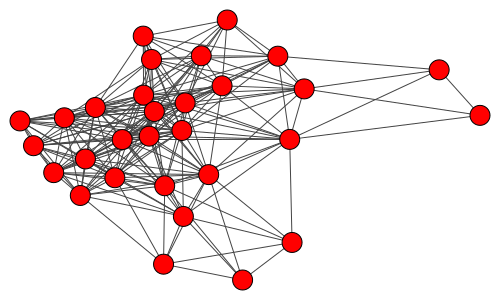

In [2]:
start = datetime.now()
layout = g.layout_fruchterman_reingold() #choose layout
plt = plot(g, layout=layout, bbox = (500, 300), margin = 20) #plot the graph with the layout
#bbox specifies size of the image (horiontal, vertical), and margin specifies space around the image
print("It took {} to generate the layout:".format(datetime.now() - start)) #we will time the computer to see how long it takes
plt

There are a few more [layouts to choose from](http://igraph.org/python/doc/tutorial/tutorial.html#layout-algorithms), for example a simple circle

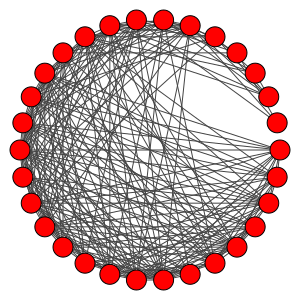

In [3]:
l = g.layout_circle()
plot(g, layout=l, bbox = (300, 300), margin=20)

You will notice that if you try any of the 3D layouts with the above code, python will err out. Unfortunately 3D visuals of netwoks require another renderer, **igraph** will not render them itself. I will cover it separately in another tutorial (WIP).

So lets get to the next step, how to modify this rendering to add colors, spacing, node sizes, and all that other fun stuff

-------------

Firstly, we need to add a few features to our graph so that we can work with it:
* `'community'` attribute - create a radom assignment of 0 to 2
* `'size'` attribute - calculate the indegree of the node and assign that as a property 

In [4]:
import random #use python's random number generator

#loop through all vertices
for vertex in g.vs:
    vertex['community'] = random.randint(0,2) #assign random community from 0 to 2
    vertex['size'] = vertex.indegree()
    
#lets see what node 0 is like as an example:
g.vs[0].attributes()

{'community': 2,
 'size': 13,
 'x': 0.0030799282521560833,
 'y': 0.2799446119751149}

Great! Now we have 2 new attributes to work with.

### Adding color to nodes

Lets add colors to the 3 communities we just created:

In [5]:
#first create a dictionary that we will use to assign colors by community
color_dict = {0: "#0ec4ff", 1: "pink", 2: "yellow"}
g.vs["color"] = [color_dict[community] for community in g.vs["community"]]

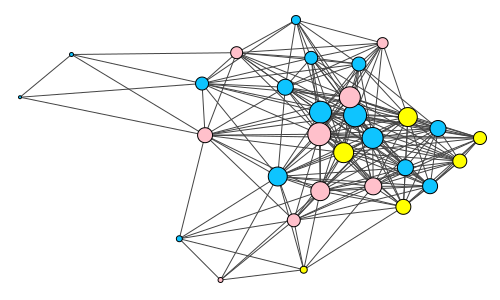

In [6]:
layout = g.layout_fruchterman_reingold()
plot(g, layout=layout, bbox = (500, 300), margin = 20)

That's getting better! You will notice that **plot** detected the attribute `'size'` and `'color'` automatically, so all we have to do is assign the required properties to these attributes. Lets change up the edge colors a bit too in order to add to the visual representation of *communities* 

We do this by checking the nodes connected by the edge -- if both are in the same community, then the color is of that communit. If they below the different communities, then the edge color is dictated by the node with the higher indegree. Hence:
* use the `g.es[].tuple` property that gives the source and target node id as a tuple
* assign color via a logical test: `if g.es[].tuple[0] == g.es[].tuple[1] then 'same color' else check_degrees(g.es[].tuple)`

In [7]:
for edge in g.es:
    tup = edge.tuple
    edge['curved'] = 0.2 #lets also curve the links so that it looks better
    if len(tup) == 2:
        if tup[0] == tup[1]:
            edge['color'] = color_dict[tup[0]]
        else:
            if g.vs[tup[0]].indegree() > g.vs[tup[1]].indegree():
                edge['color'] = color_dict[g.vs[tup[0]]['community']]
            elif g.vs[tup[0]].indegree() < g.vs[tup[1]].indegree():
                edge['color'] = color_dict[g.vs[tup[1]]['community']]
            else:
                edge['color'] = 'black'

#great, lets try to see if that worked with one node:
g.es[0]

igraph.Edge(<igraph.Graph object at 0x000002CEE56A46D8>, 0, {'color': 'yellow', 'curved': 0.2})

Okay, lets see what that looks like

It took 0:00:00.014309 to generate the layout:


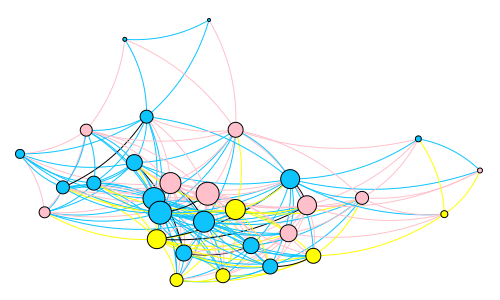

In [8]:
start = datetime.now()
layout = g.layout_fruchterman_reingold()
plt = plot(g, layout=layout, bbox = (500, 300), margin = 20)
print("It took {} to generate the layout:".format(datetime.now() - start))
plt

Looking better, lets apply this to a real life example

## Example: Dec 25, 2016 crash of Tu-154 with Alexandrov choir on board

Lets try and appy the above setup to create a visualization of an actual network. An example sample is the crash of the Russian Tu-154 aircraft of December 25, 2016. The aircraft, which was carrying the Alexandrov Ensemble choir of the Russian Armed Forces as well as the well known humanitarian activist Elizaveta Glinka, [crashed into the Black sea, killing all on board](https://en.wikipedia.org/wiki/2016_Russian_Defence_Ministry_Tupolev_Tu-154_crash). This sample was collected using [Twitter's REST (Search) API](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html), with each node representing the Russian speaking accounts who discussed this crash -- in order to analyze the reaction in Russia to the event. 

In [3]:
#use an actual specific graph -- small 4mb example, good size for experiments
path = r"C:\Serge local\Dropbox\1.Research\Research 3 - Kremlin Tweets (Online political discussions)\R3-Online-Political-Discussions\Analysis\GML_networks\Tu154_crash_REST_graph.gml"
g = Graph.Read_GML(path) 
g.summary()

'IGRAPH DN-- 3307 82999 -- \n+ attr: id (v), im (v), name (v), usernname (v)'

This example graph has 3,307 nodes and 83k edges, with a few attributes for each node -- such as `'im'` or the detected **infomap community**, as well as `'id'` or **twitter userid** of each user, and other attributes such as `'name'` and `'username'` (or **@handle**). 

Lets set up the colors as a separate function as it will be used throughout the script, and lets turn on all the bells and whistles we've used so far (including a few new ones):

In [4]:
def get_color(community):
    """
    get_color() is a simple function to return the color for a node or edge 
    """
    color_dict = {
        0: "#df0eff", #pro-gov
        1: "#0ec4ff", #opposition
        2: "#4c463e", #centrists
        3: "#73c400" #youths
    } 
    return color_dict[community] if community in color_dict else "#aaa194"

def prepare_graph(g):
    """
    prepare_graph() changes node and edge sizes and assigns color as chosen in the get_color() color dictionary
    """
    nodes_to_delete = []
    for vertex in g.vs:
        if vertex.indegree() == 0:
            nodes_to_delete.append(vertex.index)
        else:
            vertex['size'] = vertex.indegree()/100000
            vertex['color'] = get_color(vertex['im'])
    g.delete_vertices(nodes_to_delete)

    for edge in g.es:
        tup = edge.tuple
        edge['size'] = 0.1
        edge['arrow_size'] = None
        edge['curved'] = 0.2
        if len(tup) == 2:
            if tup[0] == tup[1]:
                edge['color'] = get_color(tup[0])
            else:
                if g.vs[tup[0]].indegree() > g.vs[tup[1]].indegree():
                    edge['color'] = get_color(g.vs[tup[0]]['im'])
                elif g.vs[tup[0]].indegree() < g.vs[tup[1]].indegree():
                    edge['color'] = get_color(g.vs[tup[1]]['im'])
                else:
                    edge['color'] = 'black'
    return g
    
g = prepare_graph(g)

Okay, now that the properties required are set up, lets display it!

In [ ]:
start = datetime.now()
# layout = g.layout_fruchterman_reingold()
# plt = plot(g, "Tu-154_crash_igraph.pdf", layout=layout, bbox = (500, 300), margin = 20)
print("It took {} to generate the layout:".format(datetime.now() - start))

Above we generated the plot, assigned the value to the `plt` variable, and exported it as a pdf. Lets now generate to see what it looks like:

In [ ]:
plt

Okay, that's looking somewhat acceptable. Lets export it to a pdf file so that we can save the result!